In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
from src.utils_py.io.gro import read_gro, write_gro
from src.utils_py.gro.Structure import Structure
from src.utils_py.gro.Atom import Atom
from src.utils_py.geom.Box import Box
from src.utils_py.geom.AntiSphere import AntiSphere
from src.utils_py.geom.Sphere import Sphere
from src.utils_py.geom.Cylinder import Cylinder
from src.utils_py.geom.AntiCylinder import AntiCylinder
from src.utils_py.geom.CylinderSegment import CylinderSegment
from src.utils_py.geom.AntiCylinderSegment import AntiCylinderSegment
from src.utils_py.assembler.insert import insert_point_into_shape, find_position
from src.utils_py.assembler.push import push_atoms_apart
from src.utils_py.assembler.build import build_system

In [29]:
structure = read_gro(f'server_gromos_droplet.gro')

In [28]:
os.system(f'./mixer -f server_gromos_droplet.gro -o server_gromos_droplet.gro')

0

In [25]:
with open(f'server_gromos_droplet.gro', 'w') as f:
    f.write(write_gro(structure))

In [4]:
structure.box

array([ 9.235, 13.491,  9.52 ])

In [61]:
def density(structure, type, N):
    # N = np.array([100, 150, 100])
    grid = np.zeros(N)
    dr = structure.box / N

    for a in structure.atoms:
        if (a.mol_name == type):
            id = np.floor(a.xyz / dr).astype(int)
            id -= (id == N)

            grid[id[0], id[1], id[2]] += 1
    
    if type == 'WATER':
        num = np.sum(grid) / 3
    elif type == 'DECAN':
        num = np.sum(grid) / 10
    vol = np.sum(grid > 0) * np.prod(dr)
    print('num:', num)
    print('vol:', vol)
    print('dencity:', num / vol)

In [65]:
density(structure, 'DECAN', np.array([400, 600, 400]))

num: 2086.0
vol: 0.25772767830074994
dencity: 8093.814423632784


---

In [33]:
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.gro data/sil_wd_178_595.gro')
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.xtc data/sil_wd_178_595.xtc')
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.tpr data/sil_wd_178_595.tpr')
os.system(f'scp mipt-nd:alexey/droplet_silica_gromos/sil_wd_178_595.edr data/sil_wd_178_595.edr')

0

In [31]:
os.system(f'echo 8 | gmx density -f data/sil_wd_178_595 -s data/sil_wd_178_595 -o data/density -d Y -sl 25 -dens number -ng 1 -b 0 -e 2000')
os.system(f'rm data/#*#')

Selected 8: 'WATER'


                  :-) GROMACS - gmx density, 2023-Homebrew (-:

Executable:   /opt/homebrew/bin/../Cellar/gromacs/2023/bin/gmx
Data prefix:  /opt/homebrew/bin/../Cellar/gromacs/2023
Working dir:  /Users/alexey/Dev/MD_conf
Command line:
  gmx density -f data/sil_wd_178_595 -s data/sil_wd_178_595 -o data/density -d Y -sl 25 -dens number -ng 1 -b 0 -e 2000

Reading file data/sil_wd_178_595.tpr, VERSION 2019.2 (single precision)

Select 1 group to calculate density for:
Group     0 (         System) has 12277 elements
Group     1 (          Other) has 12277 elements
Group     2 (            Sil) has  1726 elements
Group     3 (            Osi) has  3429 elements
Group     4 (            Oxi) has   211 elements
Group     5 (            Sih) has   131 elements
Group     6 (            Ooh) has   148 elements
Group     7 (            Hhh) has   148 elements
Group     8 (          WATER) has   534 elements
Group     9 (          DECAN) has  5950 elements
Last frame        200 time 2000.000   


0

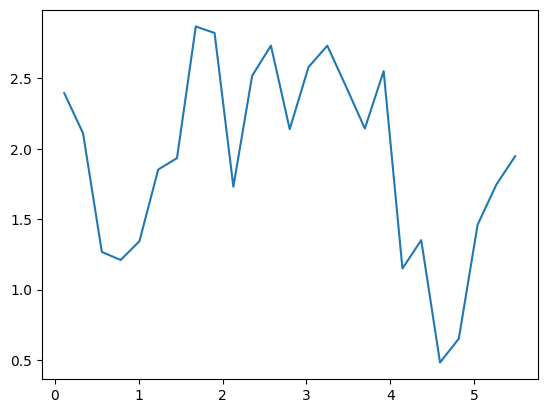

In [32]:
y, dens = np.loadtxt("data/density.xvg",comments=["@", "#"],unpack=True)
plt.plot(y, dens)

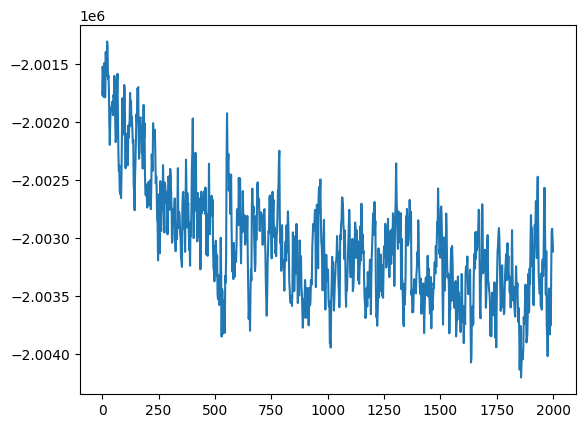

In [43]:
y, eng = np.loadtxt("data/energy.xvg",comments=["@", "#"],unpack=True)
plt.plot(y, eng)

1001
500
250
125
62
31
15
7
3
1


/var/folders/jx/xrzz7g5x5g582hdxfxg7fb680000gn/T/ipykernel_11219/2618020363.py:14: RuntimeWarning: invalid value encountered in scalar divide
  std.append(np.var(eng) / (len(eng) - 1))
/Users/alexey/Dev/MD_conf/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3787: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/alexey/Dev/MD_conf/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/alexey/Dev/MD_conf/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


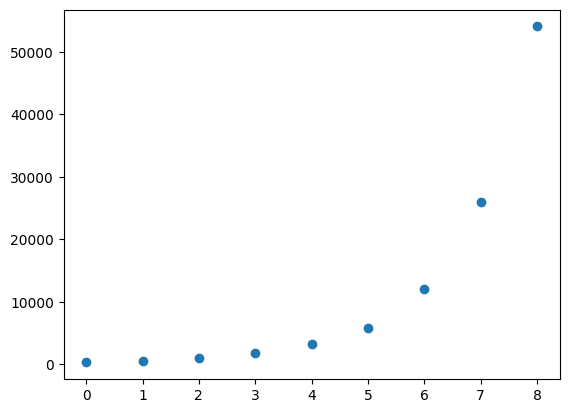

In [42]:
y, eng = np.loadtxt("data/energy.xvg",comments=["@", "#"],unpack=True)

def reduce(arr):
    size = min(arr[0::2].shape[0], arr[1::2].shape[0])
    return (arr[0:2*size:2] + arr[1:2*size:2]) / 2

n = [0]
std = [np.var(eng) / (len(eng) - 1)]
# std = [(np.mean(energy**2) - np.mean(energy)**2) / (len(energy) - 1)]
for i in range(1, 11):
    print(len(eng))
    n.append(i)
    eng = reduce(eng)
    std.append(np.var(eng) / (len(eng) - 1))
    # std.append((np.mean(energy**2) - np.mean(energy)**2) / (len(energy) - 1))

plt.scatter(x=n, y=std)

In [24]:
arr = np.empty((3, 3, 3), dtype=np.object_)

In [21]:
arr[0, 0, 0].append(1)

In [26]:
for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
        for k in range(arr.shape[2]):
            arr[i, j, k] = []

In [29]:
arr[0, 0, 0].append(1)

In [30]:
arr.astype(int)

array([[[list([1]), list([]), list([])],
        [list([]), list([]), list([])],
        [list([]), list([]), list([])]],

       [[list([]), list([]), list([])],
        [list([]), list([]), list([])],
        [list([]), list([]), list([])]],

       [[list([]), list([]), list([])],
        [list([]), list([]), list([])],
        [list([]), list([]), list([])]]], dtype=object)